In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import time
import tensorflow as tf
import time
%matplotlib inline

C:\Users\Administrator\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from DataGenerator import *

label format = [ object not present, color_labels... ]
label = [0. 0. 0. 0.]


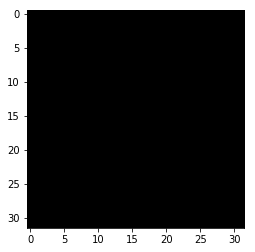

label = [1. 0. 1. 0.]


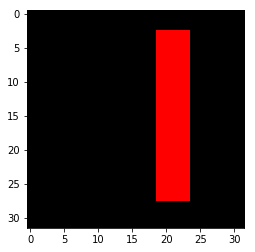

In [3]:
shape = (32,32,3)
colours = [[1,1,0], [1,0,0], [0,0.5,1]]
dg = DataGenerator(shape = shape , colours = colours, noise_mean = 0, noise_stdev = 0.0)
random.seed(101)
imgs, labels = dg.get_batch(2)
for i in range(len(imgs)):
    print("label = {}".format(labels[i]))
#     plt.imshow((imgs[i] * 255).astype("uint8"))
    plt.imshow(imgs[i])
    plt.show()

## Helper methods

Function to help intialize random weights for fully connected or convolutional layers, we leave the shape attribute as a parameter for this.

In [4]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)

Same as init_weights, but for the biases

In [5]:
def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

Create a 2D convolution using builtin conv2d from TF. From those docs:

Computes a 2-D convolution given 4-D `input` and `filter` tensors.

Given an input tensor of shape `[batch, in_height, in_width, in_channels]`
and a filter / kernel tensor of shape
`[filter_height, filter_width, in_channels, out_channels]`, this op
performs the following:

1. Flattens the filter to a 2-D matrix with shape
   `[filter_height * filter_width * in_channels, output_channels]`.
2. Extracts image patches from the input tensor to form a *virtual*
   tensor of shape `[batch, out_height, out_width,
   filter_height * filter_width * in_channels]`.
3. For each patch, right-multiplies the filter matrix and the image patch
   vector.

In [6]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

Create a max pooling layer, again using built in TF functions:

Performs the max pooling on the input.

    Args:
      value: A 4-D `Tensor` with shape `[batch, height, width, channels]` and
        type `tf.float32`.
      ksize: A list of ints that has length >= 4.  The size of the window for
        each dimension of the input tensor.
      strides: A list of ints that has length >= 4.  The stride of the sliding
        window for each dimension of the input tensor.
      padding: A string, either `'VALID'` or `'SAME'`. 

In [7]:
def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

Using the conv2d function, we'll return an actual convolutional layer here that uses an ReLu activation.

In [8]:
def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

This is a normal fully connected layer

In [9]:
def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

## Placeholders

In [10]:
print("shape = {}".format(shape))
print("[None, *shape] = {}".format([None, *shape]))
print(32*32*3)
x_shape = [None, *shape]
y_true_shape = [None, dg.label_shape[0]]
print("x_shape = {}".format(x_shape))
print("y_true_shape = {}".format(y_true_shape))
x = tf.placeholder(tf.float32,shape=x_shape)
y_true = tf.placeholder(tf.float32,shape=y_true_shape)

shape = (32, 32, 3)
[None, *shape] = [None, 32, 32, 3]
3072
x_shape = [None, 32, 32, 3]
y_true_shape = [None, 4]


Using a 6x6x3 filter. The first two values are the size of the filer and the last value corresponds to the 3 channels of the incoming image.

Last dimension of input and third dimension of filter represents the number of input channels.

In [11]:
x_image = tf.reshape(x,[-1,*shape])
convo_1 = convolutional_layer(x,shape=[6,6,3,32])
tf.Print(convo_1, [convo_1], "convo_1 :")
convo_1_pooling = max_pool_2by2(convo_1)
print(convo_1.get_shape())
print(convo_1_pooling.get_shape())

(?, 32, 32, 32)
(?, 16, 16, 32)


In [12]:
convo_2 = convolutional_layer(convo_1_pooling,shape=[6,6,32,64])
convo_2_pooling = max_pool_2by2(convo_2)
print(convo_2.get_shape())
print(convo_2_pooling.get_shape())

(?, 16, 16, 64)
(?, 8, 8, 64)


In [13]:
# Why 7 by 7 image? Because we did 2 pooling layers, so (28 /2)/2 = 7
# 64 then just comes from the output of the previous Convolution
output_size = int(8 * 8 * 64)
print(shape)
print("Output_size = {}".format(output_size))
convo_2_flat = tf.reshape(convo_2_pooling,[-1, output_size])
full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat, int(1024 / 2)))
print(convo_2_flat.get_shape())
print(full_layer_one.get_shape())

(32, 32, 3)
Output_size = 4096
(?, 4096)
(?, 512)


In [14]:
# hold_prob = tf.placeholder(tf.float32)
# full_one_dropout = tf.nn.dropout(full_layer_one,keep_prob=hold_prob)

final_output_size = dg.label_shape[0]
print("final output size = {}".format(final_output_size))
y_pred = normal_full_layer(full_layer_one, final_output_size)

final output size = 4


In [86]:
output_size = 1 + len(colours)
num_pool_layers = 2

conv1 = tf.layers.conv2d(x, 
                         filters = 32, 
                         kernel_size=[5,5], 
                         padding="same", 
                         activation=tf.nn.relu )
pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

conv2 = tf.layers.conv2d(pool1,
                          filters=64,
                          kernel_size=[5, 5],
                          padding="same",
                          activation=tf.nn.relu)
pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
pool2_flat = tf.reshape(pool2, [-1, int(shape[0] / np.power(2, num_pool_layers))  * int(shape[1] / np.power(2, num_pool_layers)) *  64])
dense1 = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
y_pred = tf.layers.dense(inputs=pool2_flat, units=output_size, activation=tf.nn.relu)

print(y_pred)

Tensor("dense_7/Relu:0", shape=(?, 4), dtype=float32)


In [87]:
print(dg.label_format)

[ object not present, color_labels... ]


In [93]:
def loss_fn(y_true, y_pred):
    
    y_true_present = y_true[..., 0]
    y_pred_present = y_pred[..., 0]
    
    y_true_class = y_true[..., 1:]
    y_pred_class = y_pred[..., 1:]
    
    object_present_loss = tf.reduce_mean(tf.square(y_true_present - y_pred_present))
    class_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true_class,logits=y_pred_class) * y_true_present)
    return object_present_loss + class_loss

In [94]:
loss = loss_fn(y_true, y_pred)

In [95]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
train = optimizer.minimize(loss)

In [96]:
saver = tf.train.Saver()

Itterations 0.0 


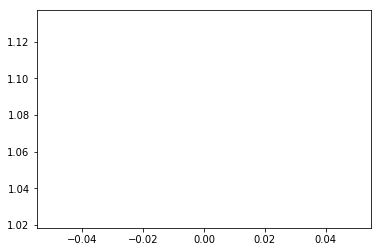

l [1. 0. 1. 0.]
p [0.21329238 0.         0.02688651 0.1016383 ]


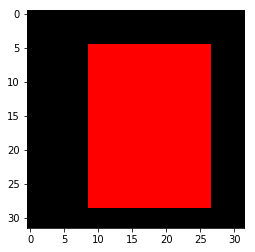

l [1. 1. 0. 0.]
p [0.17293133 0.         0.08407661 0.16361523]


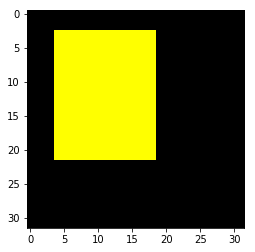

l [1. 0. 0. 1.]
p [0.12443193 0.12094382 0.         0.        ]


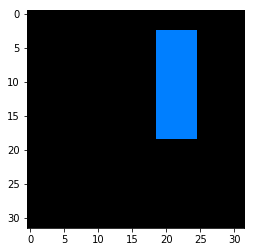

l [1. 1. 0. 0.]
p [0.13487302 0.07875005 0.00880313 0.12857343]


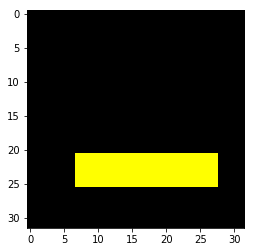

l [1. 0. 1. 0.]
p [0.10418113 0.         0.         0.01242494]


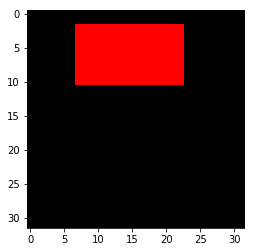

Itterations 0.1 


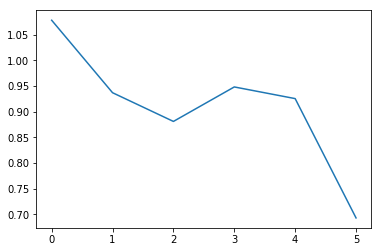

l [1. 1. 0. 0.]
p [0.51110893 0.16950116 0.         0.16982608]


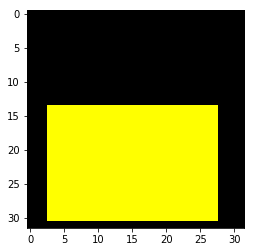

l [1. 0. 0. 1.]
p [0.46915546 0.27819908 0.         0.10340514]


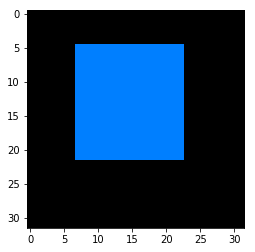

l [1. 1. 0. 0.]
p [0.04520294 0.02656039 0.         0.0715902 ]


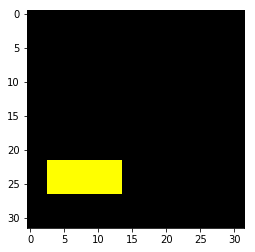

l [1. 0. 0. 1.]
p [0.25902185 0.07297786 0.         0.2530687 ]


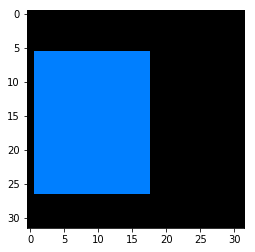

l [1. 1. 0. 0.]
p [0.27393773 0.07888873 0.00623174 0.06381608]


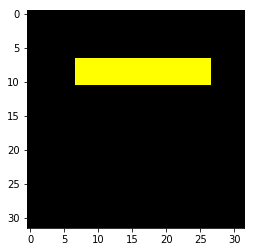

Itterations 0.2 


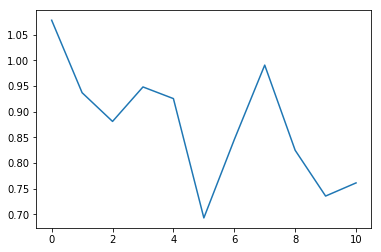

l [0. 0. 0. 0.]
p [0.01412703 0.00357422 0.         0.        ]


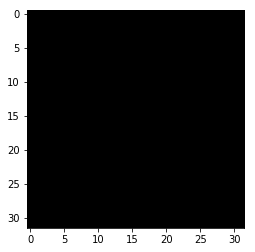

l [0. 0. 0. 0.]
p [0.01412703 0.00357422 0.         0.        ]


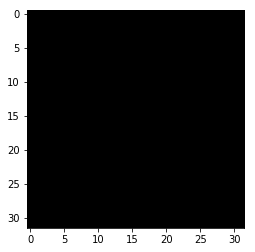

l [1. 0. 1. 0.]
p [0.66546106 0.11392186 0.         0.07330269]


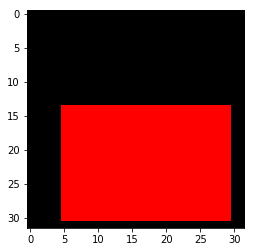

l [0. 0. 0. 0.]
p [0.01412703 0.00357422 0.         0.        ]


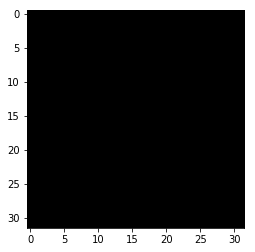

l [1. 0. 1. 0.]
p [0.61851704 0.15754156 0.         0.        ]


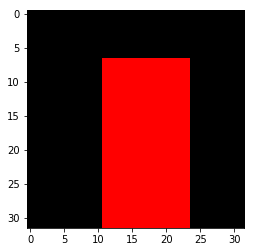

Itterations 0.3 


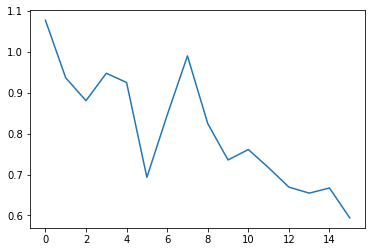

l [0. 0. 0. 0.]
p [0.02516067 0.00621854 0.         0.        ]


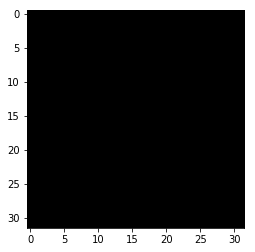

l [0. 0. 0. 0.]
p [0.02516067 0.00621854 0.         0.        ]


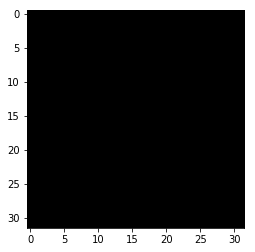

l [1. 0. 0. 1.]
p [0.76077133 0.26523918 0.         0.33377787]


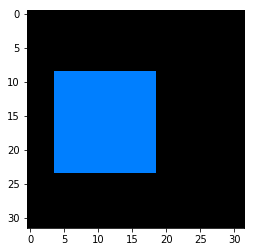

l [0. 0. 0. 0.]
p [0.02516067 0.00621854 0.         0.        ]


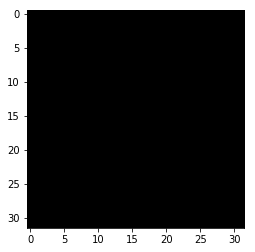

l [1. 1. 0. 0.]
p [0.58328784 0.24994332 0.12708986 0.0806046 ]


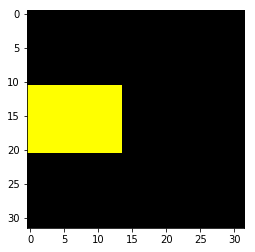

Itterations 0.4 


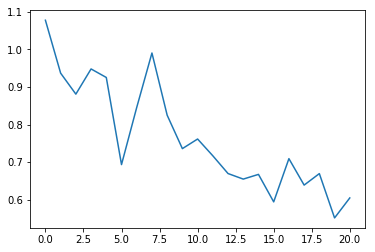

l [0. 0. 0. 0.]
p [0.03757805 0.00842266 0.         0.        ]


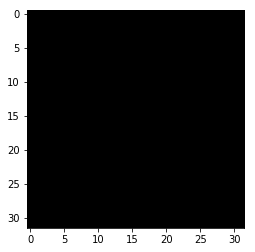

l [0. 0. 0. 0.]
p [0.03757805 0.00842266 0.         0.        ]


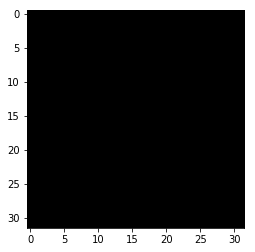

l [0. 0. 0. 0.]
p [0.03757805 0.00842266 0.         0.        ]


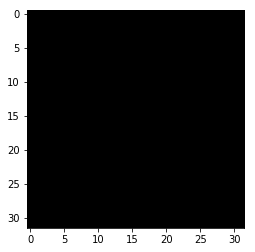

l [0. 0. 0. 0.]
p [0.03757805 0.00842266 0.         0.        ]


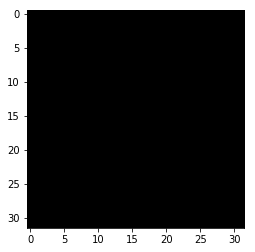

l [0. 0. 0. 0.]
p [0.03757806 0.00842266 0.         0.        ]


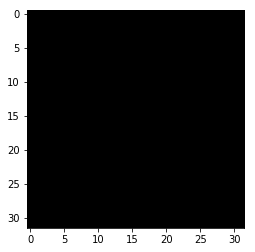

Itterations 0.5 


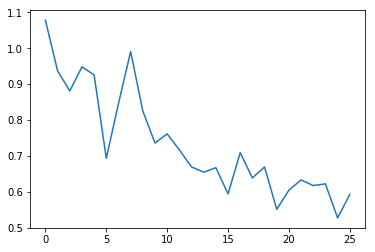

l [1. 0. 0. 1.]
p [1.1860043  0.27397797 0.         0.7448686 ]


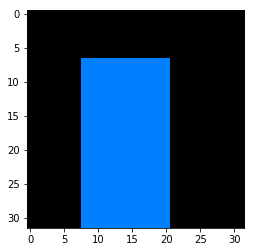

l [1. 1. 0. 0.]
p [0.83374846 0.24633206 0.03235386 0.23794037]


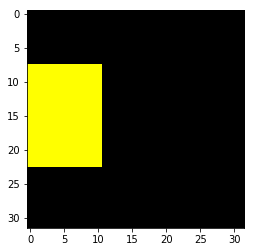

l [0. 0. 0. 0.]
p [0.04653876 0.01084742 0.         0.0019741 ]


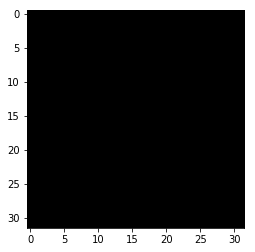

l [0. 0. 0. 0.]
p [0.04653876 0.01084742 0.         0.0019741 ]


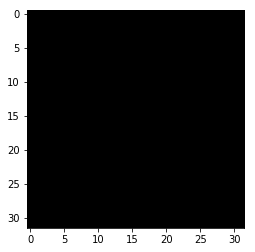

l [1. 1. 0. 0.]
p [1.4525841  0.8069418  0.06774395 0.10399295]


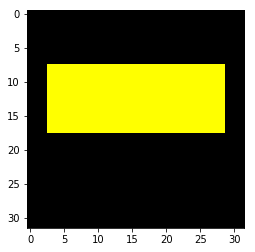

Itterations 0.6 


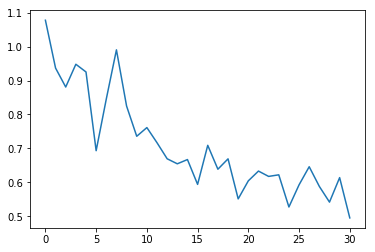

l [1. 0. 1. 0.]
p [0.5930154  0.20903903 0.01262355 0.00379538]


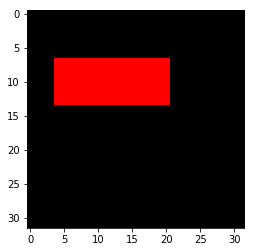

l [1. 1. 0. 0.]
p [0.9774382  0.6307747  0.         0.05967723]


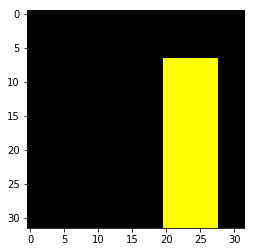

l [1. 0. 1. 0.]
p [0.45194867 0.18188022 0.05427651 0.        ]


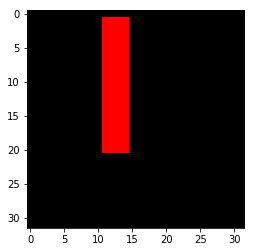

l [1. 1. 0. 0.]
p [0.8311223  0.41742688 0.         0.02059705]


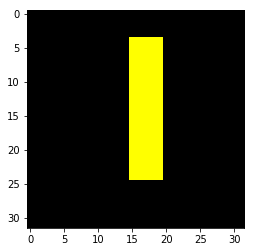

l [0. 0. 0. 0.]
p [0.05188471 0.01192582 0.         0.0059154 ]


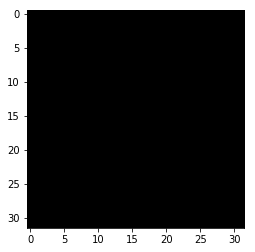

Itterations 0.7 


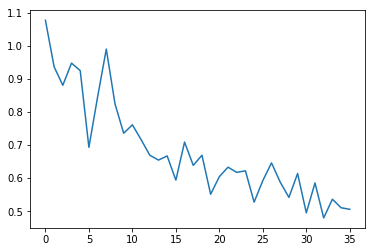

l [1. 0. 0. 1.]
p [0.5612139  0.21234627 0.         0.3134101 ]


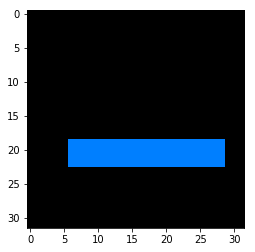

l [0. 0. 0. 0.]
p [0.05595629 0.01336545 0.         0.010672  ]


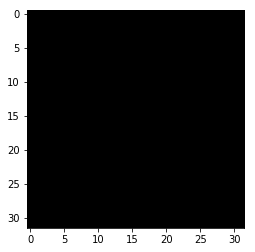

l [1. 1. 0. 0.]
p [1.0667001  0.82220453 0.         0.01504105]


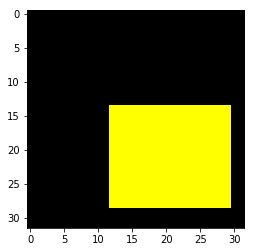

l [1. 1. 0. 0.]
p [0.22780222 0.06458851 0.01485798 0.        ]


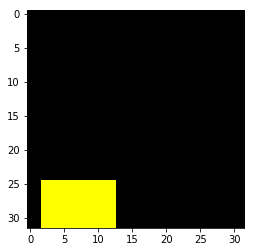

l [1. 0. 1. 0.]
p [1.1301991 0.7289109 0.0400147 0.       ]


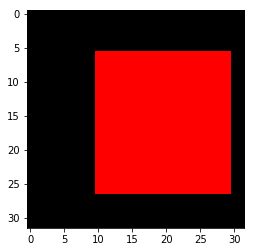

Itterations 0.8 


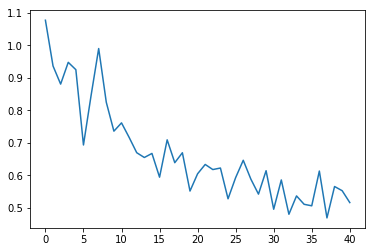

l [0. 0. 0. 0.]
p [0.06193452 0.01368449 0.00229018 0.01742976]


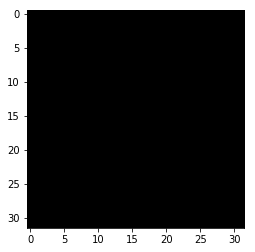

l [0. 0. 0. 0.]
p [0.06193452 0.01368449 0.00229018 0.01742976]


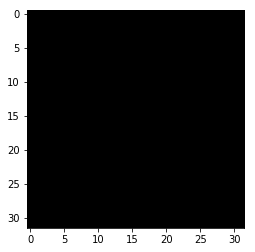

l [0. 0. 0. 0.]
p [0.06193452 0.01368449 0.00229018 0.01742976]


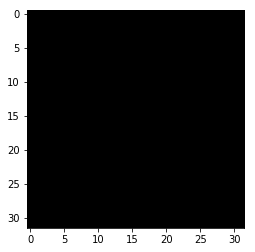

l [1. 0. 0. 1.]
p [0.7078521  0.14775911 0.01053128 0.6257928 ]


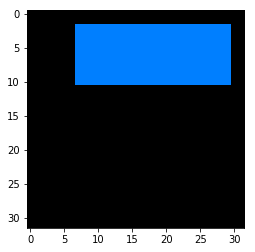

l [0. 0. 0. 0.]
p [0.06193452 0.01368449 0.00229019 0.01742976]


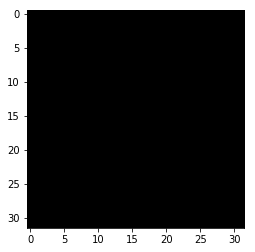

Itterations 0.9 


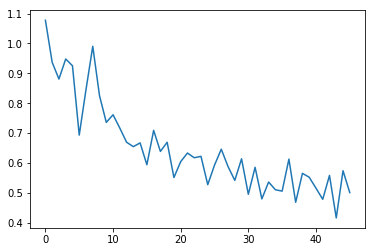

l [0. 0. 0. 0.]
p [0.07235038 0.01348289 0.01021413 0.02597879]


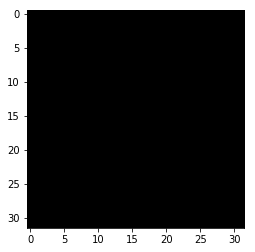

l [1. 1. 0. 0.]
p [0.36484122 0.11420561 0.1865017  0.00349057]


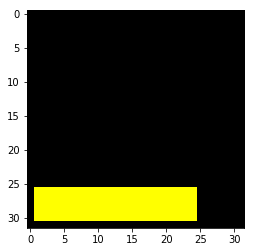

l [0. 0. 0. 0.]
p [0.07235038 0.01348289 0.01021413 0.02597879]


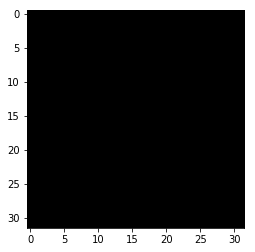

l [0. 0. 0. 0.]
p [0.07235038 0.01348289 0.01021413 0.02597879]


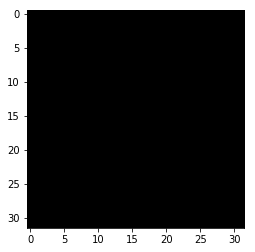

l [0. 0. 0. 0.]
p [0.07235038 0.01348289 0.01021413 0.02597879]


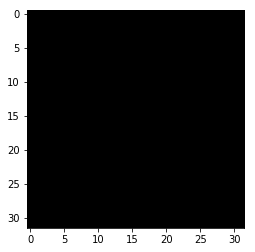

In [102]:
init = tf.global_variables_initializer()
steps = 500
random.seed(101)
batch_size = 100
losses = []
with tf.Session() as sess:
    sess.run(init)
    save_path = "C:\\Users\\Administrator\\Documents\\AIClub\\hello_world\\BasicBlockClassifier\\results"
    writer = tf.summary.FileWriter(save_path, sess.graph)
    for i in range(steps):
        batch_x , batch_y = dg.get_batch(batch_size)
        loss_out, _ = sess.run([loss, train], feed_dict={x:batch_x,y_true:batch_y})
        losses.append(loss_out)
        
        if i == 0 or i % 50 == 0 or i == steps:
            print('Itterations percentage %s ' % (i / steps) )
            plt.figure("losses")
            plt.plot(losses)
            plt.show()
            test_imgs, test_labels = dg.get_batch(5)

            predictions = sess.run(y_pred, feed_dict = {x:test_imgs, y_true:test_labels})
            for i in range(len(test_imgs)):
                print('l %s' % test_labels[i])
                print('p %s' % predictions[i])
                plt.figure(i)
                plt.imshow(test_imgs[i])
                plt.show()
                

predicted = [0.08544033 0.00304872 0.07915856 0.        ] 
y_true = [1. 1. 0. 0.] 
Loss on step 0 is 1.3183083534240723
[array([[0, 0, 0]]), [1.9167231, 0.91455966, 1.1236421]]
predicted = [0.1729932  0.         0.02488296 0.        ] 
y_true = [1. 0. 0. 1.] 
Loss on step 10 is 1.0905429124832153
[[array([[0, 0, 0]]), [1.9167231, 0.91455966, 1.1236421]], [1.3376465, 0.8270068, 1.1069756]]
predicted = [0.03627933 0.00523768 0.         0.0051426 ] 
y_true = [0. 0. 0. 0.] 
Loss on step 20 is 0.1964770406484604
[[[array([[0, 0, 0]]), [1.9167231, 0.91455966, 1.1236421]], [1.3376465, 0.8270068, 1.1069756]], [0.6257104, -0.03627933, 0.0]]
predicted = [0.8628979  0.         0.         0.34220287] 
y_true = [1. 0. 0. 1.] 
Loss on step 30 is 0.4497246742248535
[[[[array([[0, 0, 0]]), [1.9167231, 0.91455966, 1.1236421]], [1.3376465, 0.8270068, 1.1069756]], [0.6257104, -0.03627933, 0.0]], [0.32813564, 0.13710213, 0.8839362]]
predicted = [3.9737108 1.2447499 0.        0.       ] 
y_true = [1. 1. 0.

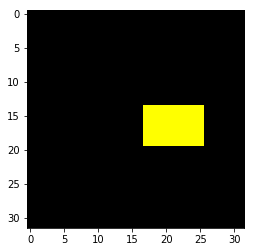

<Figure size 432x288 with 0 Axes>

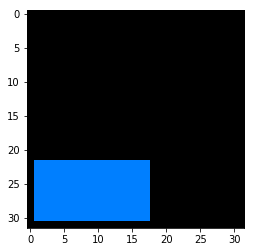

<Figure size 432x288 with 0 Axes>

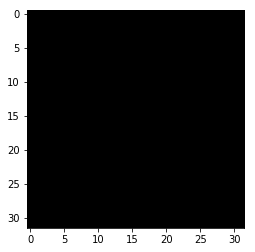

<Figure size 432x288 with 0 Axes>

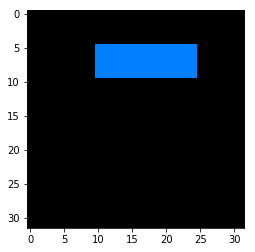

<Figure size 432x288 with 0 Axes>

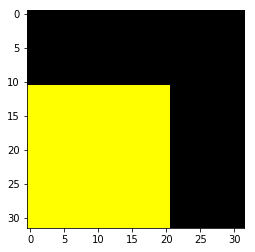

<Figure size 432x288 with 0 Axes>

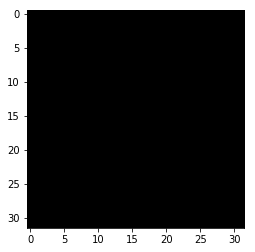

<Figure size 432x288 with 0 Axes>

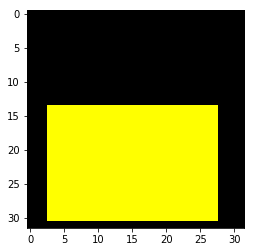

<Figure size 432x288 with 0 Axes>

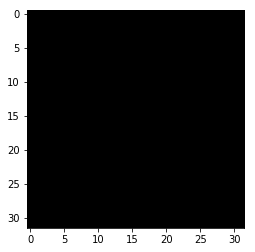

<Figure size 432x288 with 0 Axes>

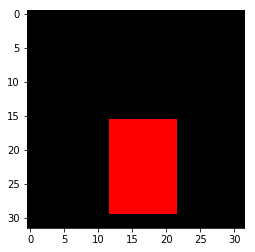

<Figure size 432x288 with 0 Axes>

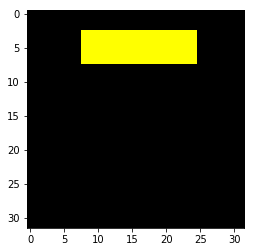

<Figure size 432x288 with 0 Axes>

In [26]:
# init = tf.global_variables_initializer()
# steps = 100
# random.seed(101)
# losses = np.array([[0,0,0]])
# batch_size = 5
# with tf.Session() as sess:
#     sess.run(init)
#     save_path = "C:\\Users\\Administrator\\Documents\\AIClub\\hello_world\\Sandbox\\custom"
#     writer = tf.summary.FileWriter(save_path, sess.graph)
#     accuracy = 0
#     for i in range(steps):
#         batch_x , batch_y = dg.get_batch(batch_size)
        
#         # grab onyly the first two columns
#         test_x, test_y = dg.get_batch(batch_size)
#         test_x = np.stack(test_x)
        
# #         object_present_matches = tf.equal(y_pred[..., 0], y_true[..., 0])
# #         class_matches = tf.equal(tf.argmax(y_pred[..., 1:],1),tf.argmax(y_true[..., 1:],1))
# #         object_present_accuracy = tf.reduce_mean(tf.cast(object_present_matches,tf.float32))
# #         class_matches_accuracy = tf.reduce_mean(tf.cast(class_matches,tf.float32))
# #         acc = tf.reduce_mean( [object_present_accuracy, class_matches_accuracy] )
# #         accuracy = sess.run([ acc, object_present_accuracy, class_matches_accuracy],feed_dict={x:test_x, y_true:test_y})
# #         accuracies.append(accuracy)
        
        
# #         if i == 1:
# #           print("batch_y = {}".format( batch_y))
#         # PRINT OUT A MESSAGE EVERY 100 STEPS
#         if i%10 == 0 or i == 0:
            
# #             print(test_y.shape)
            
#             full_layer_thinger = sess.run(full_layer_one,feed_dict={x:test_x, y_true:test_y})
# #             print(full_layer_thinger.shape)
# #             print(test_x.shape)
# #             print('Currently on step {}'.format(i))
# #             print('Accuracy is:')
#             # Test the Train Model
#             y_pred_out, y_true_out = sess.run( [y_pred, y_true], feed_dict={x:test_x, y_true:test_y} )
#             print("predicted = %s " % y_pred_out[0])
#             print("y_true = %s " % y_true_out[0])
            
#             y_true_present = y_true[0, 0]
#             y_pred_present = y_pred[0, 0]

#             y_true_class = y_true[0, 1:]
#             y_pred_class = y_pred[0, 1:]

# #             object_present_loss = tf.reduce_mean(y_true_present - y_pred_present)
# #             class_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true_class,logits=y_pred_class)) * y_true_present
# #             itteration_losses = sess.run([loss, object_present_loss, class_loss], feed_dict={x:test_x, y_true:test_y})
# #             losses = [losses, itteration_losses]
            
            
# #             print("object_present_loss = %s" % sess.run(object_present_loss, feed_dict={x:test_x, y_true:test_y}))
# #             print("class_loss = %s" % sess.run(class_loss, feed_dict={x:test_x, y_true:test_y}))
            
#             plt.figure()
#             plt.imshow(test_x[0])
            
#             tf_argmax_ypred_out = sess.run(tf.argmax(y_pred,1),feed_dict={x:test_x, y_true:test_y})
#             tf_argmax_ytrue_out = sess.run(tf.argmax(y_true,1),feed_dict={x:test_x, y_true:test_y})
# #             print("len(y_pred) = {}".format(len(y_pred_out)))
# #             print("len(tf.argmax(y_pred,1)) = {}".format(len(tf_argmax_ypred_out)))
# #             print("len(tf.argmax(y_true,1)) = {}".format(len(tf_argmax_ytrue_out)))
# #             print("y_pred = {}".format(y_pred_out))
# #             print("y_true = {}".format(y_true_out))
# #             print("tf.argmax(y_pred,1) = {}".format(tf_argmax_ypred_out))
# #             print("tf.argmax(y_true,1) = {}".format(tf_argmax_ytrue_out))
            
#             print('Loss on step {} is {}'.format(i, np.mean(itteration_losses)))
#             plt.figure()
# #             plt.plot("loss", "object_present_loss", "class_loss", data=losses, fmt="o-")
#             print(losses)
# #             print(losses[0][0])
# #             plt.plot(losses[0, ...], "loss")
# #             plt.plot(losses[1, ...], "object_present_loss")
# #             plt.plot(losses[2, ...], "class_loss")
# #             plt.show()
            
#         sess.run(train,feed_dict={x:batch_x,y_true:batch_y})
# print ("Done")


In [ ]:
plt.plot(accuracies)